Xception

Resnet50

Resnet 50 V2

Inception V3

Densenet 121

Resnet 101 V2

EfficientNet B0

VGG16

VGG19

# Xception

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


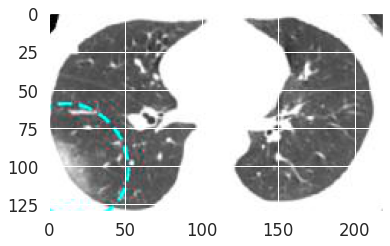

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


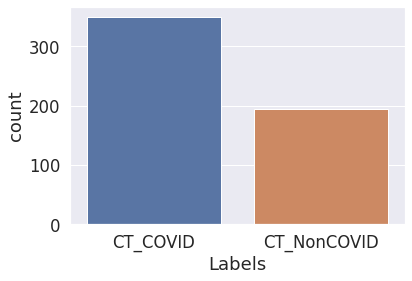

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def Xception_model():
    base_model = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(Xception_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 100352)            20861480  
_________________________________________________________________
dropout_6 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 72,275,178
Trainable params: 51,413,698
Non-trainable params: 20,861,480
_________________________________

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 11s 690ms/step - loss: 1.1637 - accuracy: 0.6673 - val_loss: 0.3354 - val_accuracy: 0.8015
Epoch 2/50
12/12 [==============================] - 7s 608ms/step - loss: 0.3569 - accuracy: 0.8625 - val_loss: 0.4930 - val_accuracy: 0.8456
Epoch 3/50
12/12 [==============================] - 7s 618ms/step - loss: 0.4421 - accuracy: 0.8467 - val_loss: 0.4542 - val_accuracy: 0.8603
Epoch 4/50
12/12 [==============================] - 7s 615ms/step - loss: 0.1897 - accuracy: 0.9298 - val_loss: 0.2519 - val_accuracy: 0.8897
Epoch 5/50
12/12 [==============================] - 7s 599ms/step - loss: 0.1855 - accuracy: 0.9326 - val_loss: 0.2630 - val_accuracy: 0.8971
Epoch 6/50
12/12 [==============================] - 7s 603ms/step - loss: 0.0805 - accuracy: 0.9717 - val_loss: 0.2696 - val_accuracy: 0.8971
Epoch 7/50
12/12 [==============================] - 7s 613ms/step - loss: 0.1108 - accuracy: 0.9626 - val_loss: 0.2590 - val_accuracy: 0.8971
Epoch

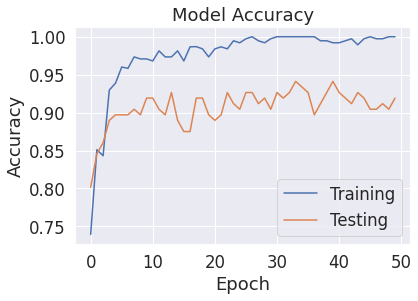

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

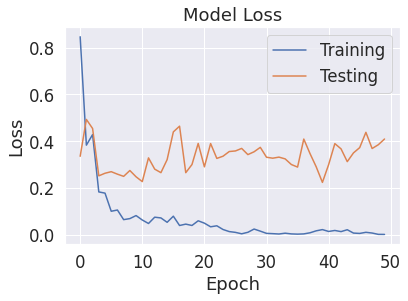

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 2s 288ms/step - loss: 0.4093 - accuracy: 0.9191
Model accuracy on validation dataset: 91.911763.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[79  8]
 [ 3 46]]


,CT_COVID,CT_NonCOVID
CT_COVID,79,8
CT_NonCOVID,3,46


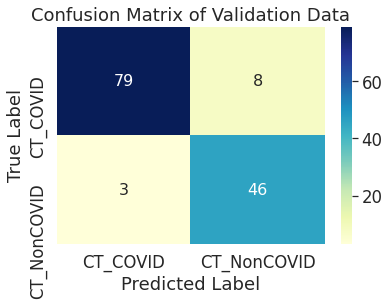

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/Xception/Xception_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/Xception/xception_weights_ct.hdf5')

# ResNet50

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


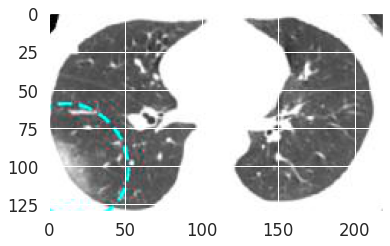

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


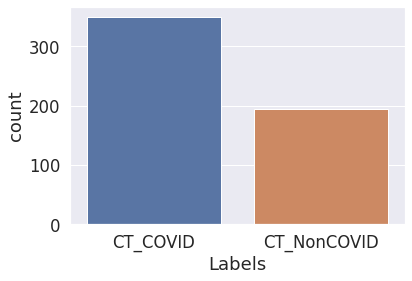

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def ResNet50_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(ResNet50_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 100352)            23587712  
_________________________________________________________________
dropout_8 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
Total params: 75,001,410
Trainable params: 51,413,698
Non-trainable params: 23,587,712
_________________________________

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 12s 654ms/step - loss: 1.3935 - accuracy: 0.5149 - val_loss: 0.7384 - val_accuracy: 0.3603
Epoch 2/50
12/12 [==============================] - 6s 534ms/step - loss: 0.6938 - accuracy: 0.6077 - val_loss: 0.6358 - val_accuracy: 0.6397
Epoch 3/50
12/12 [==============================] - 6s 535ms/step - loss: 0.6672 - accuracy: 0.6024 - val_loss: 0.6383 - val_accuracy: 0.6397
Epoch 4/50
12/12 [==============================] - 6s 521ms/step - loss: 0.6639 - accuracy: 0.6372 - val_loss: 0.6155 - val_accuracy: 0.6397
Epoch 5/50
12/12 [==============================] - 6s 521ms/step - loss: 0.6794 - accuracy: 0.5746 - val_loss: 0.6112 - val_accuracy: 0.6397
Epoch 6/50
12/12 [==============================] - 6s 520ms/step - loss: 0.5898 - accuracy: 0.6978 - val_loss: 0.5699 - val_accuracy: 0.6912
Epoch 7/50
12/12 [==============================] - 6s 525ms/step - loss: 0.5546 - accuracy: 0.6939 - val_loss: 0.5162 - val_accuracy: 0.7721
Epoch

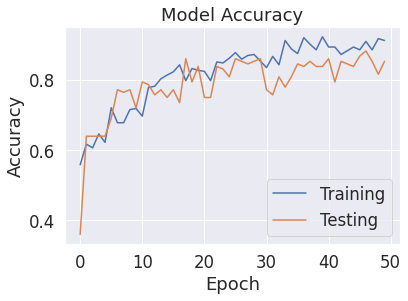

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

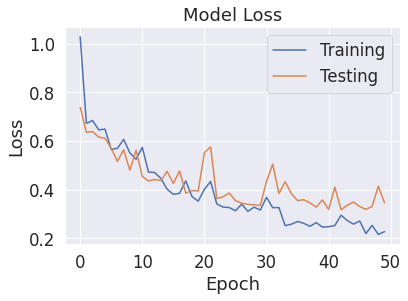

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 1s 195ms/step - loss: 0.3457 - accuracy: 0.8529
Model accuracy on validation dataset: 85.294116.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[84  3]
 [17 32]]


,CT_COVID,CT_NonCOVID
CT_COVID,84,3
CT_NonCOVID,17,32


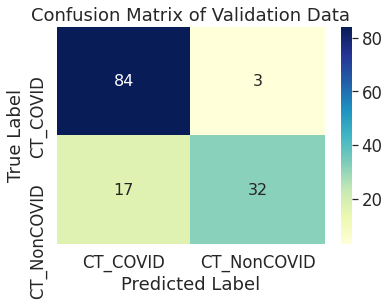

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/ResNet50/ResNet50_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/ResNet50/ResNet50_weights_ct.hdf5')

# ResNet50 v2

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, ResNet50, ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


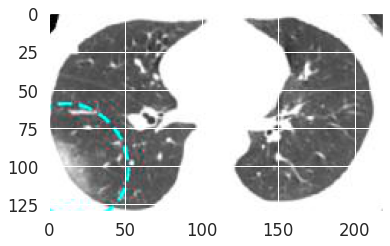

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


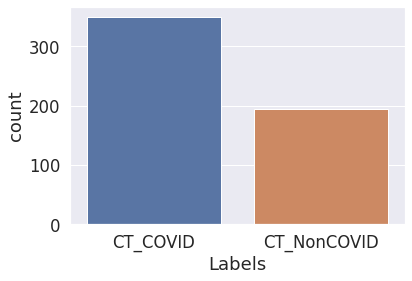

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def ResNet50V2_model():
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(ResNet50V2_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

94674944/94668760 [==============================] - 2s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 100352)            23564800  
_________________________________________________________________
dropout_10 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 130       
Total params: 74,978,498
Trainable params: 51,413,698
N

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 12s 692ms/step - loss: 3.6810 - accuracy: 0.5831 - val_loss: 0.6877 - val_accuracy: 0.7279
Epoch 2/50
12/12 [==============================] - 6s 517ms/step - loss: 0.5356 - accuracy: 0.7911 - val_loss: 0.2972 - val_accuracy: 0.8971
Epoch 3/50
12/12 [==============================] - 6s 509ms/step - loss: 0.3023 - accuracy: 0.8866 - val_loss: 0.3540 - val_accuracy: 0.9118
Epoch 4/50
12/12 [==============================] - 6s 508ms/step - loss: 0.2380 - accuracy: 0.9190 - val_loss: 0.2789 - val_accuracy: 0.8897
Epoch 5/50
12/12 [==============================] - 6s 518ms/step - loss: 0.1350 - accuracy: 0.9441 - val_loss: 0.2771 - val_accuracy: 0.9044
Epoch 6/50
12/12 [==============================] - 6s 517ms/step - loss: 0.0510 - accuracy: 0.9814 - val_loss: 0.2914 - val_accuracy: 0.9191
Epoch 7/50
12/12 [==============================] - 6s 507ms/step - loss: 0.0721 - accuracy: 0.9734 - val_loss: 0.2319 - val_accuracy: 0.9191
Epoch

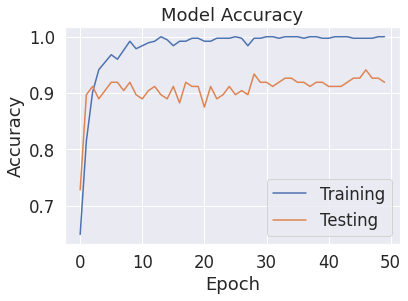

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

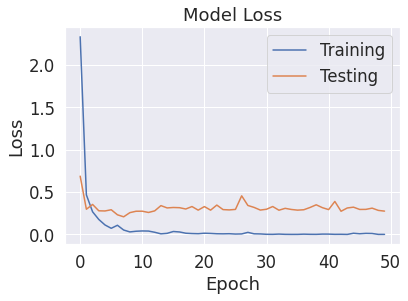

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 2s 269ms/step - loss: 0.2751 - accuracy: 0.9191
Model accuracy on validation dataset: 91.911763.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1
 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[85  2]
 [ 9 40]]


,CT_COVID,CT_NonCOVID
CT_COVID,85,2
CT_NonCOVID,9,40


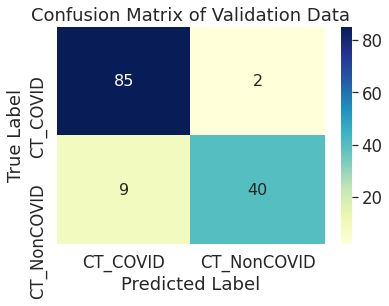

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/ResNet50 V2/ResNet50v2_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/ResNet50 V2/ResNet50v2_weights_ct.hdf5')

# Inception V3

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, InceptionV3, ResNet50, ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


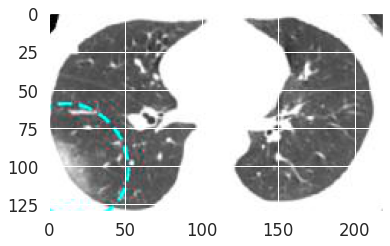

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


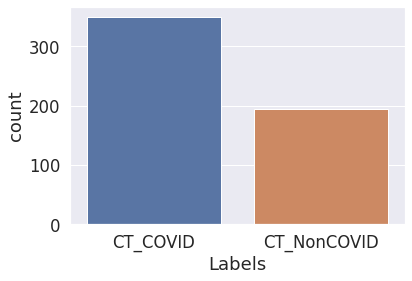

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def InceptionV3_model():
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(InceptionV3_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Functional)         (None, 51200)             21802784  
_________________________________________________________________
dropout_12 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               26214912  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 130       
Total params: 48,050,658
Trainable params: 26,247,874
N

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 13s 660ms/step - loss: 0.2200 - accuracy: 0.9291 - val_loss: 0.5351 - val_accuracy: 0.8750
Epoch 2/50
12/12 [==============================] - 6s 464ms/step - loss: 0.0671 - accuracy: 0.9750 - val_loss: 0.4797 - val_accuracy: 0.8750
Epoch 3/50
12/12 [==============================] - 6s 455ms/step - loss: 0.0402 - accuracy: 0.9861 - val_loss: 0.5888 - val_accuracy: 0.8603
Epoch 4/50
12/12 [==============================] - 6s 458ms/step - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.5780 - val_accuracy: 0.8676
Epoch 5/50
12/12 [==============================] - 6s 468ms/step - loss: 0.0166 - accuracy: 0.9972 - val_loss: 0.5374 - val_accuracy: 0.8676
Epoch 6/50
12/12 [==============================] - 6s 456ms/step - loss: 0.0098 - accuracy: 0.9958 - val_loss: 0.4867 - val_accuracy: 0.9118
Epoch 7/50
12/12 [==============================] - 6s 456ms/step - loss: 0.0105 - accuracy: 0.9982 - val_loss: 0.5086 - val_accuracy: 0.8897
Epoch

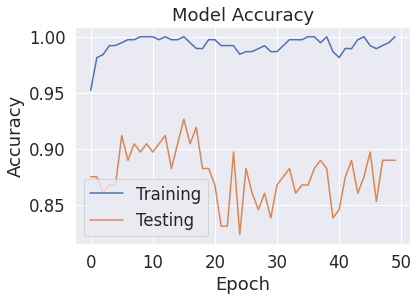

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

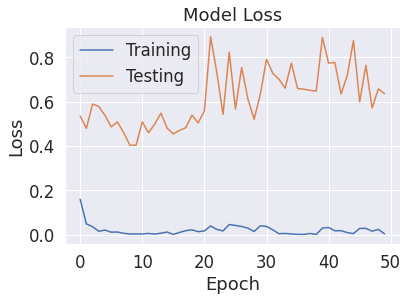

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 2s 157ms/step - loss: 0.6360 - accuracy: 0.8897
Model accuracy on validation dataset: 88.970590.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1
 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[83  4]
 [11 38]]


,CT_COVID,CT_NonCOVID
CT_COVID,83,4
CT_NonCOVID,11,38


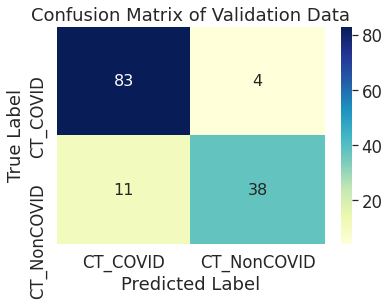

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/Inception V3/inceptionv3_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/Inception V3/inceptionv3_weights_ct.hdf5')

# DenseNet121

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, DenseNet121, InceptionV3, ResNet50, ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


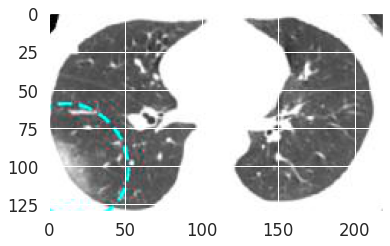

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


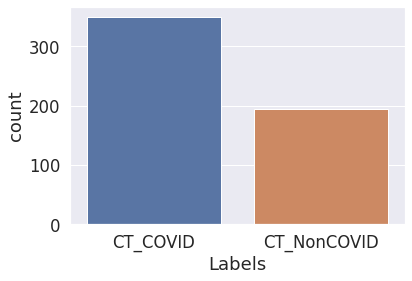

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def DenseNet121_model():
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(DenseNet121_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_7 (Functional)         (None, 50176)             7037504   
_________________________________________________________________
dropout_14 (Dropout)         (None, 50176)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               25690624  
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 130       
Total params: 32,761,090
Trainable params: 25,723,586
N

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 19s 905ms/step - loss: 1.4070 - accuracy: 0.7209 - val_loss: 0.9199 - val_accuracy: 0.7941
Epoch 2/50
12/12 [==============================] - 6s 483ms/step - loss: 0.3407 - accuracy: 0.8735 - val_loss: 0.6833 - val_accuracy: 0.7941
Epoch 3/50
12/12 [==============================] - 6s 496ms/step - loss: 0.4297 - accuracy: 0.8452 - val_loss: 0.4797 - val_accuracy: 0.8529
Epoch 4/50
12/12 [==============================] - 6s 482ms/step - loss: 0.2093 - accuracy: 0.9305 - val_loss: 0.4150 - val_accuracy: 0.8824
Epoch 5/50
12/12 [==============================] - 6s 488ms/step - loss: 0.1890 - accuracy: 0.9315 - val_loss: 0.4169 - val_accuracy: 0.8824
Epoch 6/50
12/12 [==============================] - 6s 481ms/step - loss: 0.2132 - accuracy: 0.9404 - val_loss: 0.3496 - val_accuracy: 0.8971
Epoch 7/50
12/12 [==============================] - 6s 477ms/step - loss: 0.1053 - accuracy: 0.9613 - val_loss: 0.4368 - val_accuracy: 0.8897
Epoch

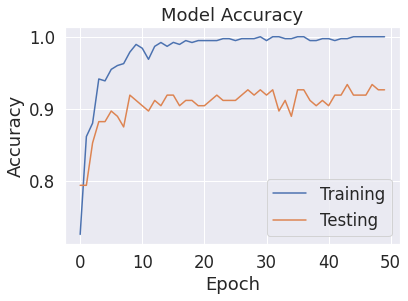

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

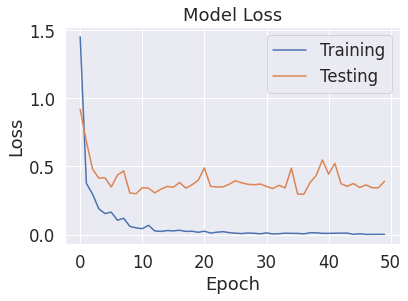

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 4s 405ms/step - loss: 0.3914 - accuracy: 0.9265
Model accuracy on validation dataset: 92.647058.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[84  3]
 [ 7 42]]


,CT_COVID,CT_NonCOVID
CT_COVID,84,3
CT_NonCOVID,7,42


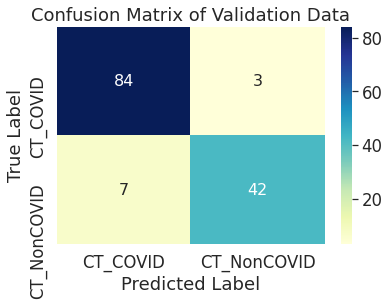

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/densenet 121/densenet 121_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/densenet 121/densenet 121_weights_ct.hdf5')

# ResNet101 V2

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2, VGG16, ResNet101, Xception, DenseNet121, InceptionV3, ResNet50, ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


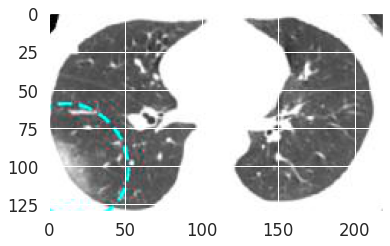

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


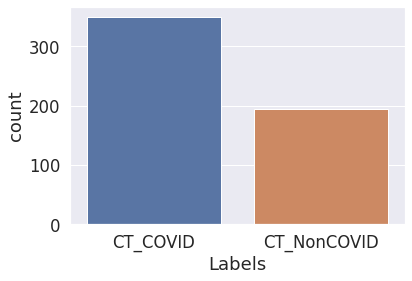

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def ResNet101V2_model():
    base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(ResNet101V2_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

171319296/171317808 [==============================] - 6s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_8 (Functional)         (None, 100352)            42626560  
_________________________________________________________________
dropout_16 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 130       
Total params: 94,040,258
Trainable params: 51,413,698

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 17s 828ms/step - loss: 1.8911 - accuracy: 0.6025 - val_loss: 0.6572 - val_accuracy: 0.6912
Epoch 2/50
12/12 [==============================] - 8s 634ms/step - loss: 0.4799 - accuracy: 0.8105 - val_loss: 0.2650 - val_accuracy: 0.8897
Epoch 3/50
12/12 [==============================] - 8s 630ms/step - loss: 0.2436 - accuracy: 0.8760 - val_loss: 0.3647 - val_accuracy: 0.8235
Epoch 4/50
12/12 [==============================] - 8s 623ms/step - loss: 0.1833 - accuracy: 0.9212 - val_loss: 0.2003 - val_accuracy: 0.9265
Epoch 5/50
12/12 [==============================] - 8s 626ms/step - loss: 0.1094 - accuracy: 0.9507 - val_loss: 0.2492 - val_accuracy: 0.8897
Epoch 6/50
12/12 [==============================] - 8s 628ms/step - loss: 0.0885 - accuracy: 0.9601 - val_loss: 0.1597 - val_accuracy: 0.9338
Epoch 7/50
12/12 [==============================] - 8s 621ms/step - loss: 0.0620 - accuracy: 0.9693 - val_loss: 0.1503 - val_accuracy: 0.9559
Epoch

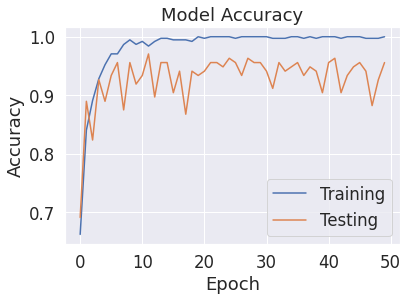

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

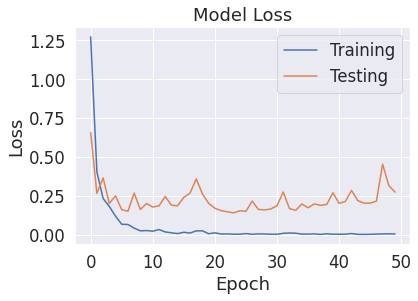

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 4s 313ms/step - loss: 0.2731 - accuracy: 0.9559
Model accuracy on validation dataset: 95.588237.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1
 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[83  4]
 [ 2 47]]


,CT_COVID,CT_NonCOVID
CT_COVID,83,4
CT_NonCOVID,2,47


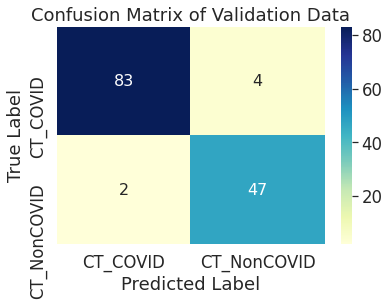

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/resnet 101 v2/resnet 101 v2_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/resnet 101 v2/resnet 101 v2_weights_ct.hdf5')

# EfficientNet B0

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2,VGG16, ResNet101, Xception, DenseNet121, InceptionV3, ResNet50, ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


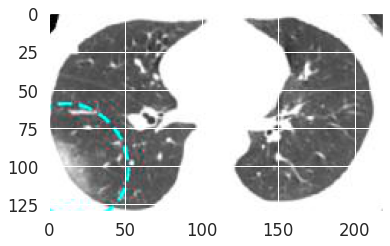

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


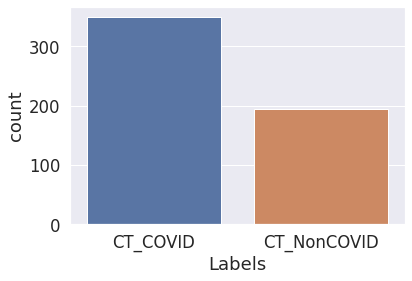

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def EfficientNetB0_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(EfficientNetB0_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_11 (Functional)        (None, 62720)             4049571   
_________________________________________________________________
dropout_22 (Dropout)         (None, 62720)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               32113152  
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 130       
Total params: 36,195,685
Trainable params: 32,146,114
Non-trainable params: 4,049,571
_________________________________

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 14s 605ms/step - loss: 1.9891 - accuracy: 0.5030 - val_loss: 0.7207 - val_accuracy: 0.3603
Epoch 2/50
12/12 [==============================] - 5s 407ms/step - loss: 0.8382 - accuracy: 0.5563 - val_loss: 0.7435 - val_accuracy: 0.3603
Epoch 3/50
12/12 [==============================] - 5s 403ms/step - loss: 0.8402 - accuracy: 0.5357 - val_loss: 0.6872 - val_accuracy: 0.6397
Epoch 4/50
12/12 [==============================] - 5s 403ms/step - loss: 0.7618 - accuracy: 0.5682 - val_loss: 0.8133 - val_accuracy: 0.3603
Epoch 5/50
12/12 [==============================] - 5s 406ms/step - loss: 0.7608 - accuracy: 0.5353 - val_loss: 0.6577 - val_accuracy: 0.6397
Epoch 6/50
12/12 [==============================] - 5s 407ms/step - loss: 0.6675 - accuracy: 0.6355 - val_loss: 0.6927 - val_accuracy: 0.6324
Epoch 7/50
12/12 [==============================] - 5s 408ms/step - loss: 0.7215 - accuracy: 0.6045 - val_loss: 0.6649 - val_accuracy: 0.6397
Epoch

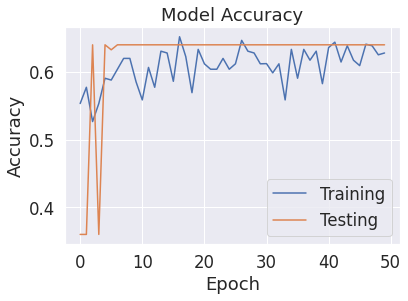

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

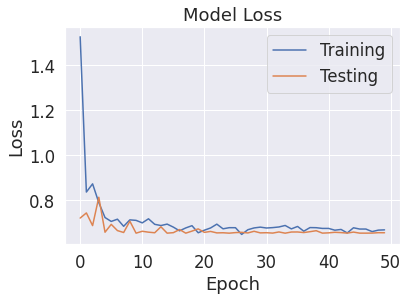

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 2s 119ms/step - loss: 0.6553 - accuracy: 0.6397
Model accuracy on validation dataset: 63.970590.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[87  0]
 [49  0]]


,CT_COVID,CT_NonCOVID
CT_COVID,87,0
CT_NonCOVID,49,0


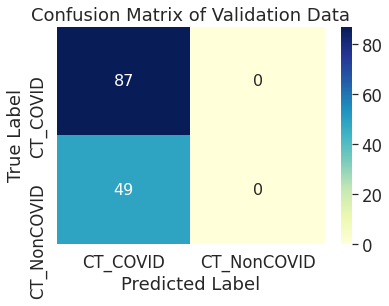

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/efficient net b0/EfficientNetB0_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/COVID CT DS Github (K)/efficient net b0/EfficientNetB0_weights_ct.hdf5')

# VGG 16

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 500
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


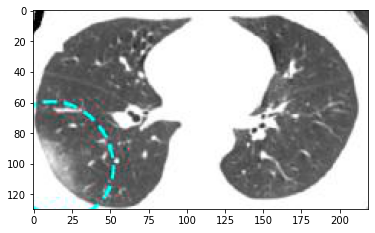

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


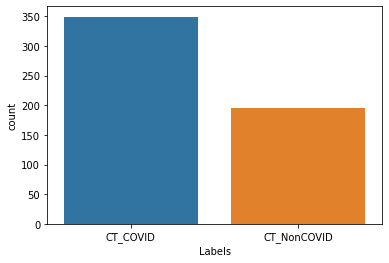

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def VGG16_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(VGG16_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Functional)         (None, 25088)             14714688  
_________________________________________________________________
dropout_12 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 130       
Total params: 27,593,218
Trainable params: 12,878,530
Non-trainable params: 14,714,688
_________________________________

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
12/12 [==============================] - 7s 520ms/step - loss: 0.7024 - accuracy: 0.6662 - val_loss: 0.3735 - val_accuracy: 0.8456
Epoch 2/500
12/12 [==============================] - 5s 395ms/step - loss: 0.3699 - accuracy: 0.8268 - val_loss: 0.3577 - val_accuracy: 0.8750
Epoch 3/500
12/12 [==============================] - 5s 402ms/step - loss: 0.1995 - accuracy: 0.9033 - val_loss: 0.3801 - val_accuracy: 0.8750
Epoch 4/500
12/12 [==============================] - 5s 395ms/step - loss: 0.1885 - accuracy: 0.9258 - val_loss: 0.2556 - val_accuracy: 0.8897
Epoch 5/500
12/12 [==============================] - 5s 401ms/step - loss: 0.2179 - accuracy: 0.9306 - val_loss: 0.2244 - val_accuracy: 0.9118
Epoch 6/500
12/12 [==============================] - 5s 388ms/step - loss: 0.1258 - accuracy: 0.9464 - val_loss: 0.2463 - val_accuracy: 0.8897
Epoch 7/500
12/12 [==============================] - 5s 390ms/step - loss: 0.1002 - accuracy: 0.9617 - val_loss: 0.2284 - val_accuracy: 0.9191

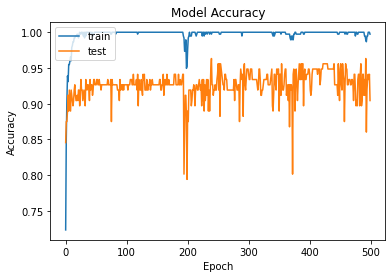

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

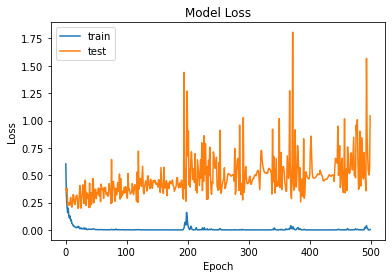

In [ ]:
#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 1s 123ms/step - loss: 1.0425 - accuracy: 0.9044
Model accuracy on validation dataset: 90.441179.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[87  0]
 [13 36]]


,CT_COVID,CT_NonCOVID
CT_COVID,87,0
CT_NonCOVID,13,36


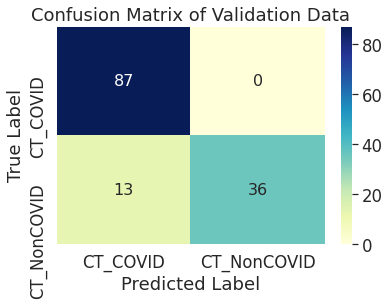

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('vgg_ct.h5')
covid_model.save_weights('vgg_weights_ct.hdf5')

# VGG 19

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


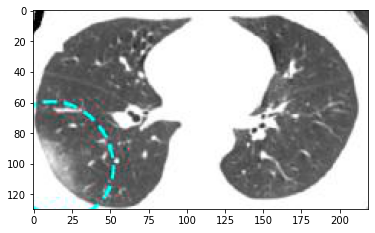

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


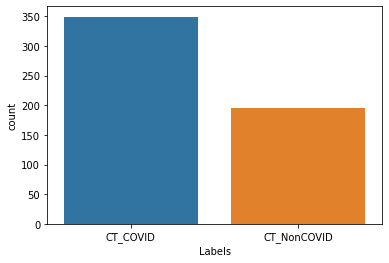

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def VGG19_model():
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(VGG19_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25088)             20024384  
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 32,902,914
Trainable params: 12,878,530
N

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 15s 550ms/step - loss: 0.8696 - accuracy: 0.6048 - val_loss: 0.5753 - val_accuracy: 0.6397
Epoch 2/50
12/12 [==============================] - 6s 389ms/step - loss: 0.4954 - accuracy: 0.7481 - val_loss: 0.3979 - val_accuracy: 0.8309
Epoch 3/50
12/12 [==============================] - 5s 404ms/step - loss: 0.3452 - accuracy: 0.8457 - val_loss: 0.3638 - val_accuracy: 0.8676
Epoch 4/50
12/12 [==============================] - 5s 401ms/step - loss: 0.3110 - accuracy: 0.8625 - val_loss: 0.3398 - val_accuracy: 0.8603
Epoch 5/50
12/12 [==============================] - 5s 401ms/step - loss: 0.1850 - accuracy: 0.9372 - val_loss: 0.3322 - val_accuracy: 0.8603
Epoch 6/50
12/12 [==============================] - 5s 403ms/step - loss: 0.2621 - accuracy: 0.8785 - val_loss: 0.2763 - val_accuracy: 0.8676
Epoch 7/50
12/12 [==============================] - 5s 410ms/step - loss: 0.1825 - accuracy: 0.9054 - val_loss: 0.3489 - val_accuracy: 0.8603
Epoch

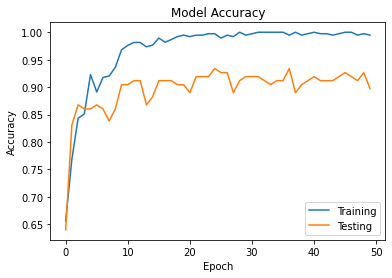

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

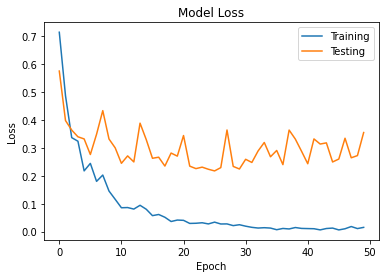

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 1s 266ms/step - loss: 0.3550 - accuracy: 0.8971
Model accuracy on validation dataset: 89.705884.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[85  2]
 [12 37]]


,CT_COVID,CT_NonCOVID
CT_COVID,85,2
CT_NonCOVID,12,37


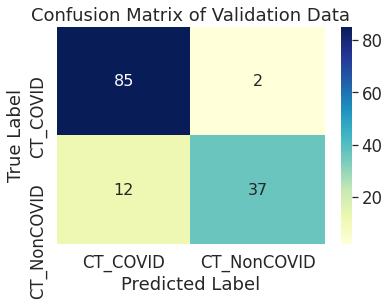

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('vgg_ct.h5')
covid_model.save_weights('vgg_weights_ct.hdf5')

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

from tensorflow.keras.models import Model, load_model

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/CT DS Github'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))



/content/drive/MyDrive/CT DS Github/CT_COVID/2020.03.30.20047985-p9-56%3.png
(130, 219, 3)


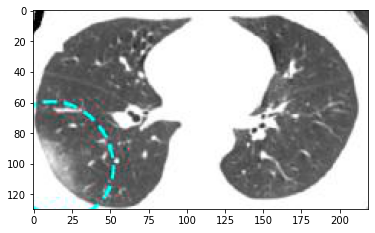

In [ ]:
print(imagePaths[50])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(544, 224, 224, 3) (544,)


     Labels
0  CT_COVID
1  CT_COVID
2  CT_COVID
3  CT_COVID
4  CT_COVID 

CT_COVID       349
CT_NonCOVID    195
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


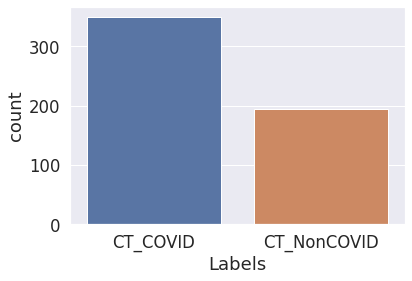

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['CT_COVID' 'CT_NonCOVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(408, 224, 224, 3)
(408, 2)
(136, 224, 224, 3)
(136, 2)


In [ ]:
#Transfer learning with VGG16

def Xception_model():
    base_model = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(Xception_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100352)            20861480  
_________________________________________________________________
dropout_2 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 72,275,178
Trainable params: 51,413,698
N

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 9s 556ms/step - loss: 1.2079 - accuracy: 0.5692 - val_loss: 0.5574 - val_accuracy: 0.7426
Epoch 2/50
12/12 [==============================] - 5s 416ms/step - loss: 0.4253 - accuracy: 0.8180 - val_loss: 0.3981 - val_accuracy: 0.8456
Epoch 3/50
12/12 [==============================] - 5s 422ms/step - loss: 0.3395 - accuracy: 0.8452 - val_loss: 0.4356 - val_accuracy: 0.8456
Epoch 4/50
12/12 [==============================] - 5s 422ms/step - loss: 0.3106 - accuracy: 0.8889 - val_loss: 0.3203 - val_accuracy: 0.8750
Epoch 5/50
12/12 [==============================] - 5s 427ms/step - loss: 0.1830 - accuracy: 0.9243 - val_loss: 0.2705 - val_accuracy: 0.8971
Epoch 6/50
12/12 [==============================] - 5s 412ms/step - loss: 0.1618 - accuracy: 0.9138 - val_loss: 0.2612 - val_accuracy: 0.8897
Epoch 7/50
12/12 [==============================] - 5s 406ms/step - loss: 0.0952 - accuracy: 0.9579 - val_loss: 0.2578 - val_accuracy: 0.8897
Epoch 

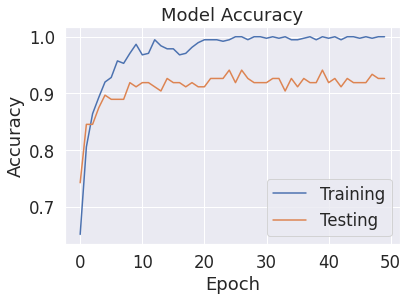

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()




# #Accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

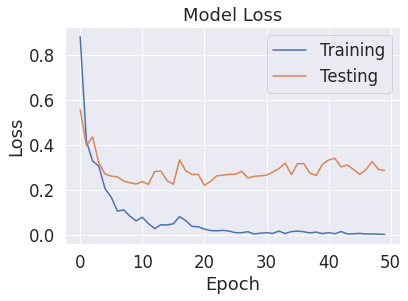

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_loss.png')
plt.show()





# #Loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

5/5 [==============================] - 2s 196ms/step - loss: 0.2864 - accuracy: 0.9265
Model accuracy on validation dataset: 92.647058.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1]
136
['CT_COVID' 'CT_NonCOVID']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1]
136


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[82  5]
 [ 5 44]]


,CT_COVID,CT_NonCOVID
CT_COVID,82,5
CT_NonCOVID,5,44


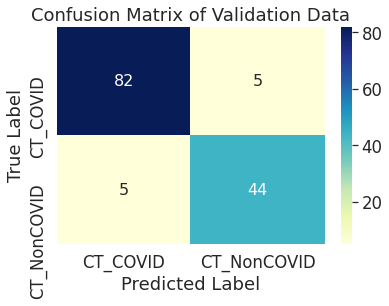

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('vgg_ct.h5')
covid_model.save_weights('vgg_weights_ct.hdf5')